In [1]:
#machine learning script, basing on VGG16 
import os
from os.path import join
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Dense
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.data_utils import get_file
import json, copy
from keras.models import Model
from keras.optimizers import Adam
from keras import backend
import csv

Using Theano backend.


In [2]:
data_path = join(os.getcwd(), *['data', 'playground']

In [3]:
class BinaryVgg16():
    def __init__(self, data_path, target_size=(224, 224)):
        self.data_path = data_path
        self.train_path = join(data_path, 'train')
        self.valid_path = join(data_path, 'valid')
        self.test_path = join(data_path, 'test')
        
        self.target_size = target_size
        
        self.model = VGG16(weights = 'imagenet')
        self.prepare_binary_vgg16()
        
        self.generator = ImageDataGenerator()
        
        self.sample_images = None
        
    def prepare_binary_vgg16(self):
        model = VGG16(weights='imagenet')
        model.layers.pop()
        for layer in model.layers: layer.trainable=False
        new_top = Dense(1, activation='sigmoid')(model.layers[-1].output)
        new_model = Model(model.input, new_top)
        new_model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy', metrics=['accuracy'])
        self.new_model = new_model
    
    def generate_images(self, path, shuffle, class_mode, batch_size):
        return self.generator.flow_from_directory(path, shuffle = shuffle, class_mode = class_mode, batch_size = batch_size, target_size = self.target_size)
    
        
    def show_validation_images(self, img_nbr=4):
        self.prepare_sample_images(img_nbr)
        plots(self.sample_images, titles=self.sample_titles, figtitle='Validation images with original class')
        
    def prepare_sample_images(self, imgs_num=4):
        if self.sample_images is not None and len(self.sample_images) is imgs_num:
            return
        generator  = self.generate_images(self.valid_path, shuffle=True, class_mode='binary', batch_size=imgs_num)
        self.sample_images, self.sample_titles = next(generator)
        
    def show_sample_predictions_by_original_model(self, img_nbr=4):
        self.prepare_sample_images(img_nbr)
        predictions = self.model.predict(self.sample_images)
        plot_with_most_probable_classes(self.sample_images, predictions, get_classes(), 3, 'Sample predictions by original model')
        
    def show_sample_predictions(self, img_nbr=4):
        self.prepare_sample_images(img_nbr)
        predictions = self.new_model.predict(self.sample_images)
        plots(self.sample_images, titles = [str(p[0]) for p in predictions], figtitle='Predictions by new model')
        
    def fit(self, batch_size, epochs = 1):
        train_batches = self.generate_images(self.train_path, shuffle=True, class_mode='binary', batch_size=batch_size)
        valid_batches = self.generate_images(self.valid_path, shuffle=True, class_mode='binary', batch_size=batch_size)
        self.new_model.fit_generator(train_batches,
                             steps_per_epoch=train_batches.samples/batch_size,
                             validation_data  = valid_batches,
                             validation_steps = valid_batches.samples/batch_size,
                              nb_epoch = epochs
                            )
    def add_to_misjudged(self, lst, image, original_label, predicted_label, list_max_length = 4):
        lst.append((image, original_label, predicted_label))
        lst.sort(key=lambda tpl: -abs(tpl[1]-tpl[2]))
        if len(lst) > list_max_length:
            return lst[:list_max_length]
        else:
            return lst

    def plot_tuples(self, tuples, figtitle = None):
        if tuples:
            plots([e[0] for e in tuples], titles=['original: '+str(e[1])+'\npredicted: '+str(e[2]) for e in tuples], figtitle=figtitle)
        else:
            print('Empty tuples list')
    
    def show_misjudged_classes(self, img_nbr=4):
        batch_size=4
        generator = self.generate_images(self.valid_path, shuffle=False, class_mode='binary', batch_size=batch_size)
        misjudged_class_0 = []
        misjudged_class_1 = []
        for i in range(generator.samples//batch_size):
            imgs, labels = next(generator)
            predictions = [p[0] for p in self.new_model.predict(imgs)]
            for i in range(len(labels)):
                if abs(labels[i] - predictions[i]) > 0.5:
                    if labels[i] == 0.0:
                        misjudged_class_0 = self.add_to_misjudged(misjudged_class_0, imgs[i], labels[i], predictions[i], img_nbr)
                    elif labels[i] == 1.0:
                        misjudged_class_1 = self.add_to_misjudged(misjudged_class_1, imgs[i], labels[i], predictions[i], img_nbr)
        self.plot_tuples(misjudged_class_0, figtitle = 'Most misjudged class 0 samples')
        self.plot_tuples(misjudged_class_1, figtitle = 'Most misjudged class 1 samples')
    
    def show_confusing_images(self, img_nbr=4):
        batch_size = 4
        generator = self.generate_images(self.valid_path, shuffle=False, class_mode='binary', batch_size=batch_size)
        confusing_0 = []
        confusing_1 = []
        for i in range(generator.samples//batch_size):
            imgs, labels = next(generator)
            predictions = [p[0] for p in self.new_model.predict(imgs)]
            for i in range(len(labels)):
                if labels[i] == 0.0:
                    confusing_0.append((imgs[i], labels[i], predictions[i]))
                elif labels[i] == 1.0:
                    confusing_1.append((imgs[i], labels[i], predictions[i]))
        confusing_0.sort(key=lambda tpl: abs(0.5 - tpl[2]))
        confusing_1.sort(key=lambda tpl: abs(0.5 - tpl[2]))
        self.plot_tuples(confusing_0[:img_nbr], figtitle = 'Most confusing samples (closest to 0.5) for class 0')
        self.plot_tuples(confusing_1[:img_nbr], figtitle = 'Most confusing samples (closest to 0.5) for class 1')
        
        
    def save(self, filepath):
        self.new_model.save_weights(filepath)
        
    def load(self, filepath):
        self.new_model.load_weights(filepath)
        
    def save_test_predictions(self):
        batch_size = 1
        generator = self.generate_images(self.test_path, shuffle = False, batch_size = batch_size, class_mode=None)
        batch_results = self.new_model.predict_generator(generator, steps=generator.samples//batch_size)
        results = [elem for result in batch_results for elem in result]
        image_ids = [f.split('/')[-1].replace('.jpg','') for f in generator.filenames]
        save_results(list(zip(image_ids, trim_predictions(results, 0.025))))
     

In [4]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None, figtitle=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    f.suptitle(figtitle)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def get_classes():
        fname = 'imagenet_class_index.json'
        fpath = get_file(fname, join('http://files.fast.ai/models/', fname), cache_subdir='models')
        with open(fpath) as f:
            class_dict = json.load(f)
        return [class_dict[str(i)][1] for i in range(len(class_dict))]
    

def plot_with_most_probable_classes(images, predictions, classes, k, figtitle = None):
    #plots images with titles that are k most probable classes
    most_probable_labels  = [[classes[index] + '/' + '{:10.2f}'.format(p[index]) for index in np.argsort(p)[::-1][:k]] for p in predictions]
    titles = ['\n'.join(lst) for lst in most_probable_labels]
    plots(images, titles=titles, figtitle=figtitle)
    
def trim_predictions(predictions, border):
    for i in range(len(predictions)):
        if predictions[i] > 1 - border:
            predictions[i] = 1 - border
        elif predictions[i] < border:
            predictions[i] = border
    return predictions

def save_results(id_result_tuples, filename = 'result.csv'):
    with open(filename, 'w+') as f:
        wr = csv.writer(f)
        wr.writerows(id_result_tuples)


In [5]:
model = BinaryVgg16(data_path, (224, 224))

Found 20 images belonging to 2 classes.


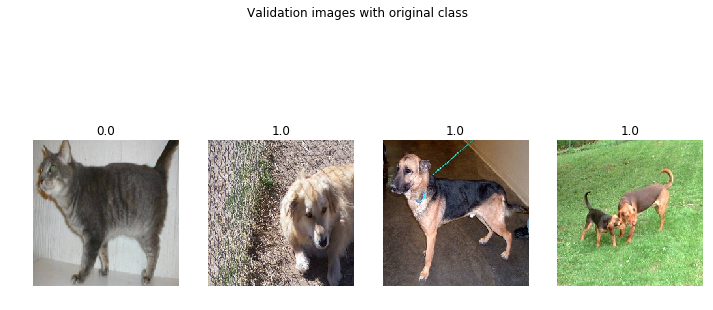

In [6]:
model.show_validation_images()

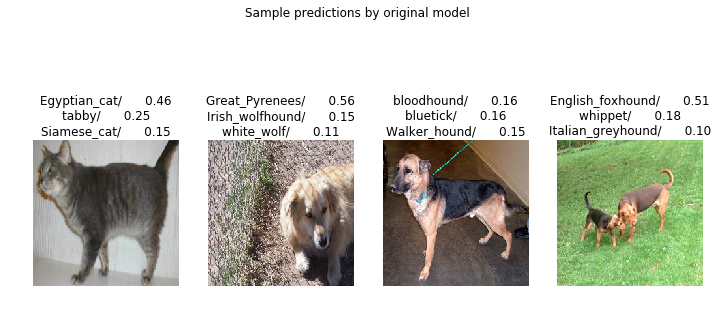

In [7]:
model.show_sample_predictions_by_original_model()

In [8]:
model.fit(10)

Found 100 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


/home/prd/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/prd/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=10.0, validation_data=<keras.pre..., epochs=1, validation_steps=2.0)`


Epoch 1/1
10/10 [==============================] - 63s - loss: 0.7861 - acc: 0.7100 - val_loss: 0.2093 - val_acc: 0.8500


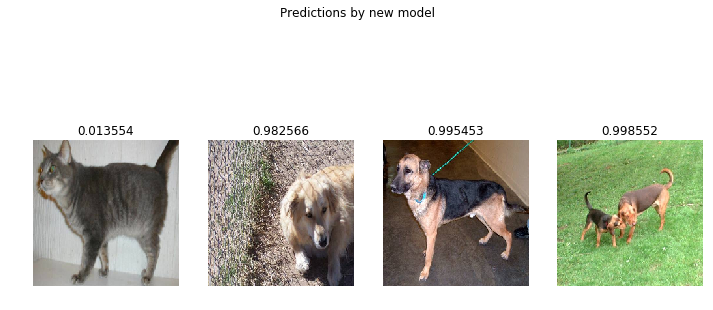

In [9]:
model.show_sample_predictions()

Found 20 images belonging to 2 classes.


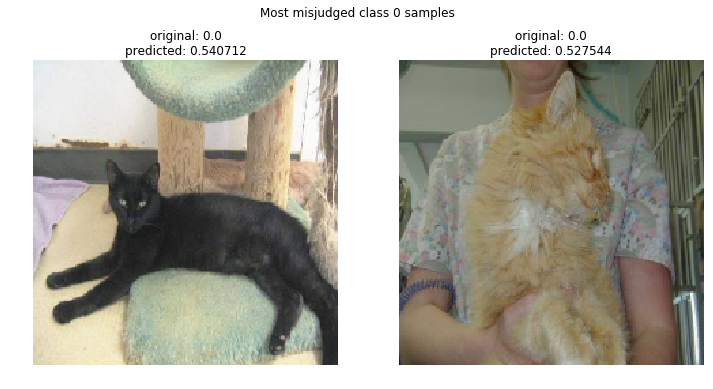

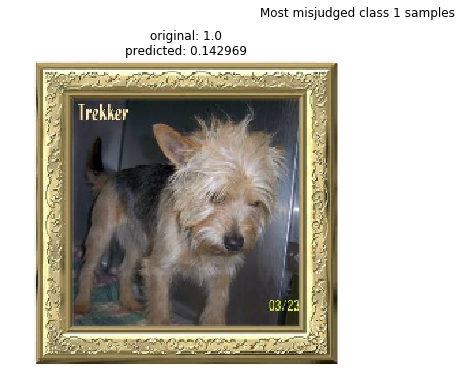

In [10]:
model.show_misjudged_classes()

Found 20 images belonging to 2 classes.


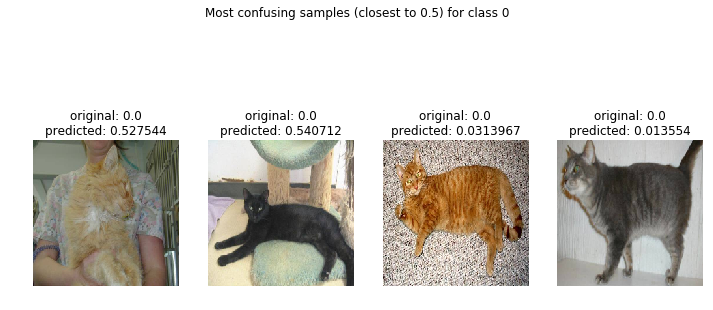

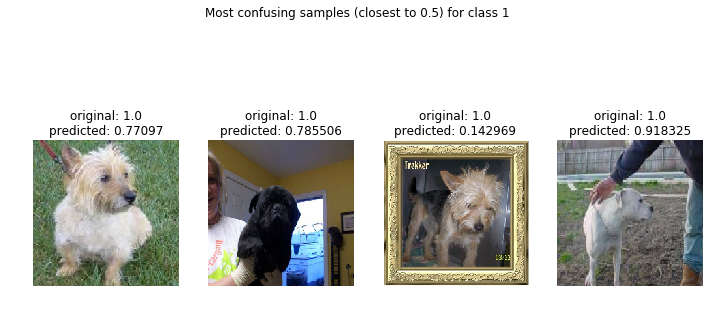

In [11]:
model.show_confusing_images()

In [12]:
model.save('model_cats_dogs_binary.h5')

In [13]:
model.save_test_predictions()

Found 10 images belonging to 1 classes.
